In [14]:
# !wget https://dysk.agh.edu.pl/s/G6ZNziBRbEEcMeN/download/Bike-Sharing-Dataset.zip -O Bike-Sharing-Dataset.zip
# !unzip Bike-Sharing-Dataset.zip
# !cat Readme.txt

In [15]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder.appName("BikerRental").master("local[*]").getOrCreate()
df = spark.read.csv('day.csv', header=True, inferSchema=True)
df.show(5)
df.printSchema()

+-------+----------+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+------+----------+----+
|instant|    dteday|season| yr|mnth|holiday|weekday|workingday|weathersit|    temp|   atemp|     hum|windspeed|casual|registered| cnt|
+-------+----------+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+------+----------+----+
|      1|2011-01-01|     1|  0|   1|      0|      6|         0|         2|0.344167|0.363625|0.805833| 0.160446|   331|       654| 985|
|      2|2011-01-02|     1|  0|   1|      0|      0|         0|         2|0.363478|0.353739|0.696087| 0.248539|   131|       670| 801|
|      3|2011-01-03|     1|  0|   1|      0|      1|         1|         1|0.196364|0.189405|0.437273| 0.248309|   120|      1229|1349|
|      4|2011-01-04|     1|  0|   1|      0|      2|         1|         1|     0.2|0.212122|0.590435| 0.160296|   108|      1454|1562|
|      5|2011-01-05|     1|  0|   1|      0|      3|   

In [16]:
if str(df.schema['dteday'].dataType) != 'DateType':
    df = df.withColumn("dteday", to_date(col("dteday"), "yyyy-MM-dd"))
    print("\\nSchema after date conversion:")
    df.printSchema()


\nSchema after date conversion:
root
 |-- instant: integer (nullable = true)
 |-- dteday: date (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)



In [17]:
pdf = df.toPandas()

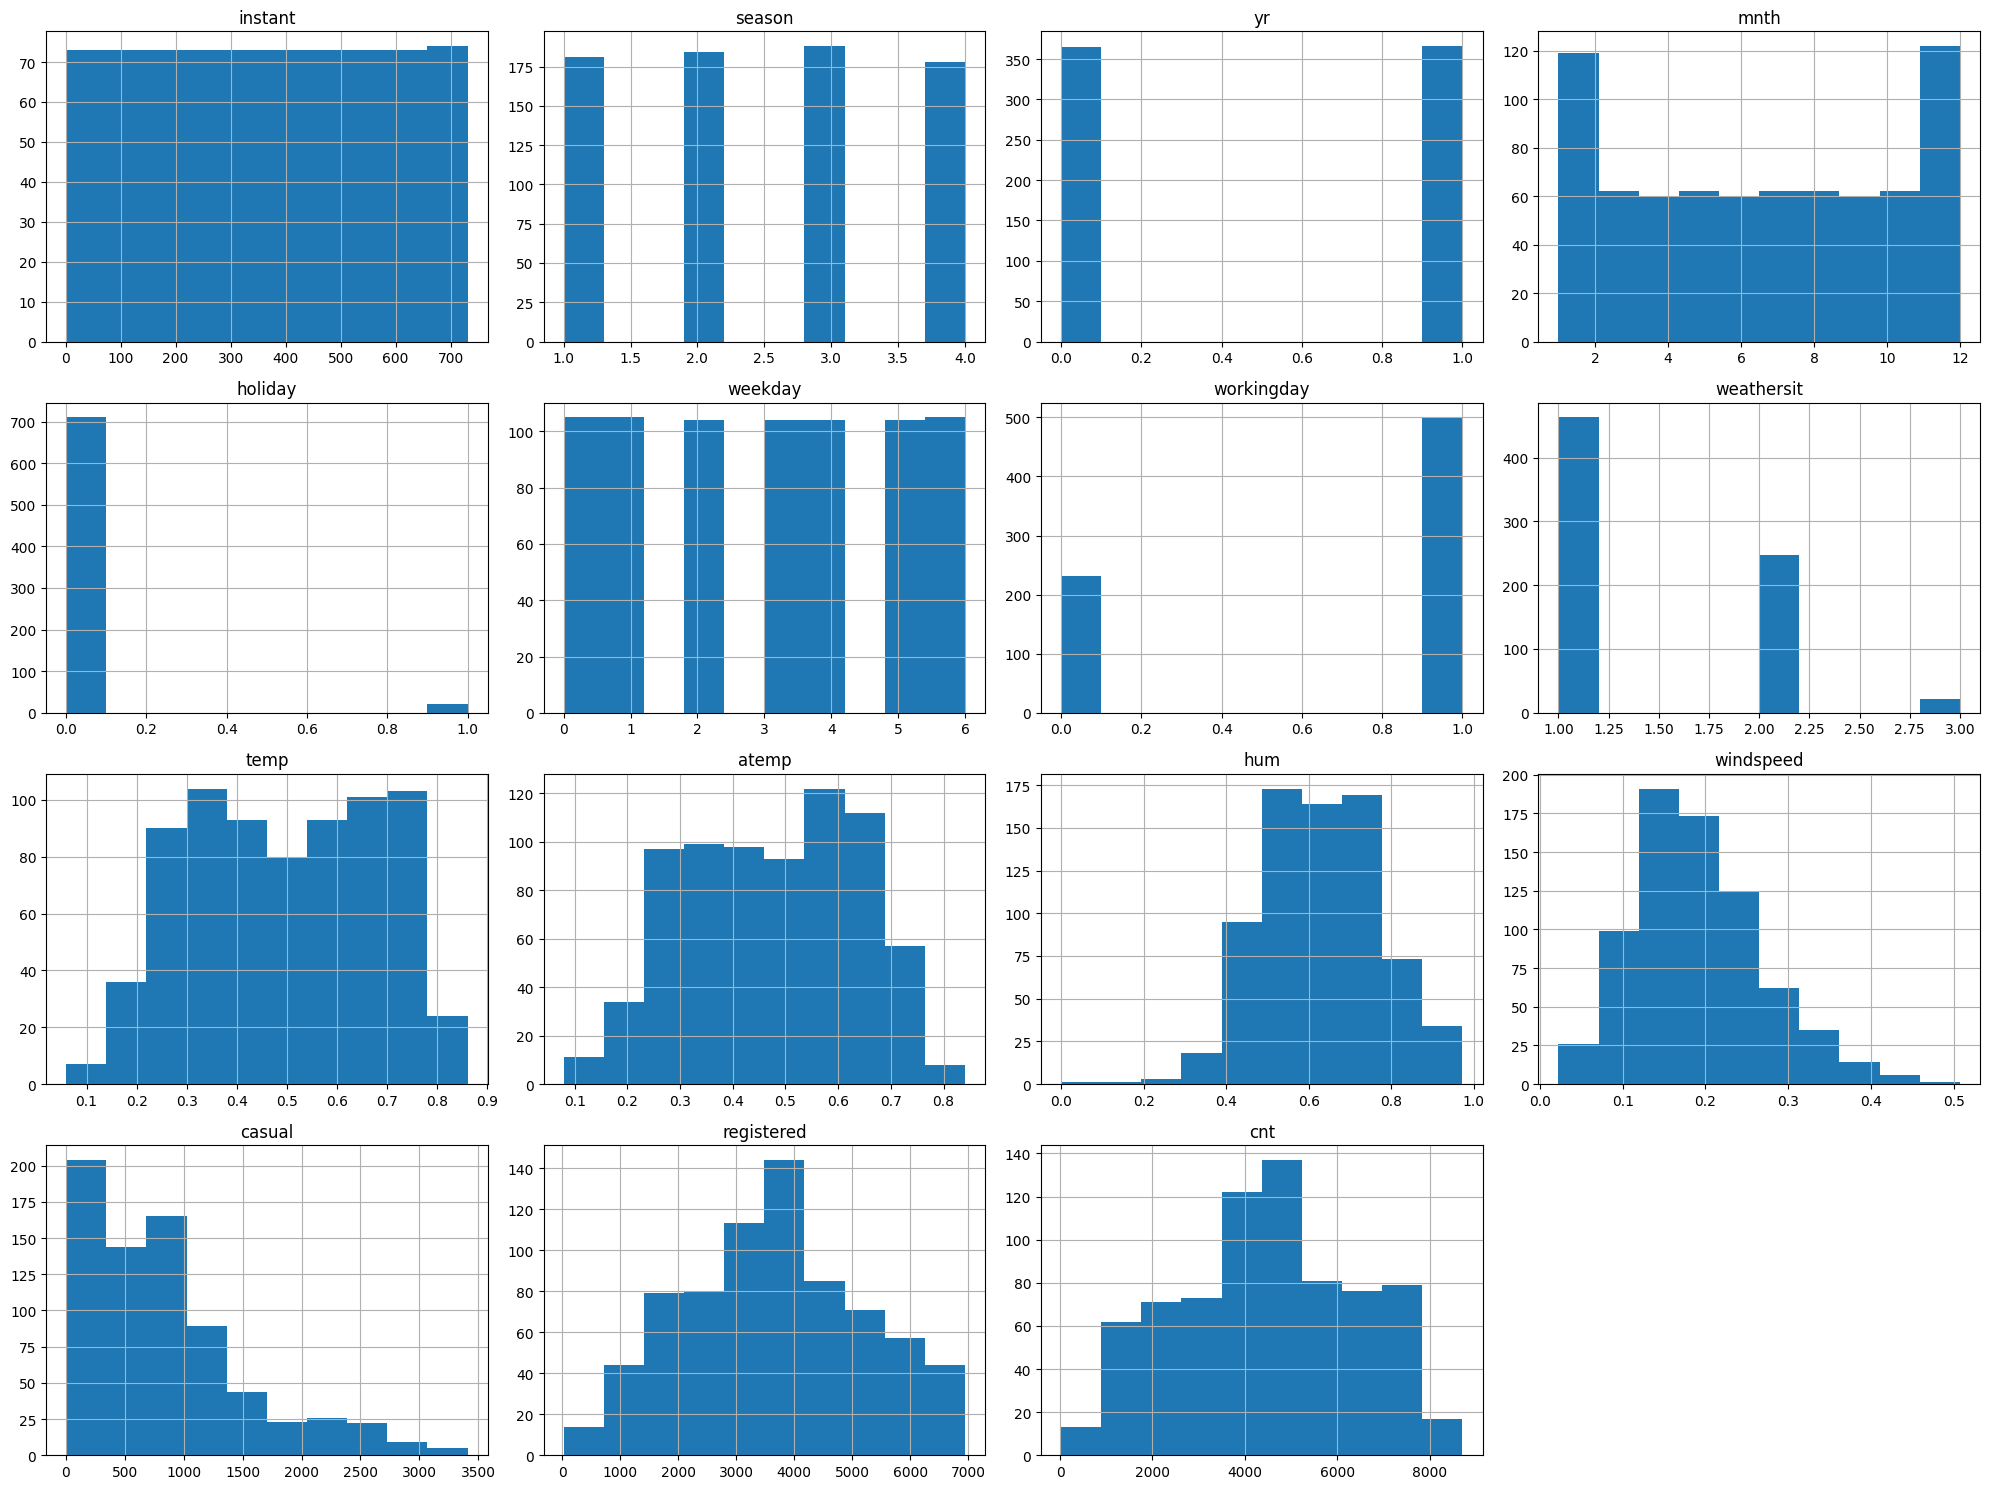

In [18]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 15)
pdf.hist()
plt.tight_layout()
plt.show()


\nPlotting counts over time:


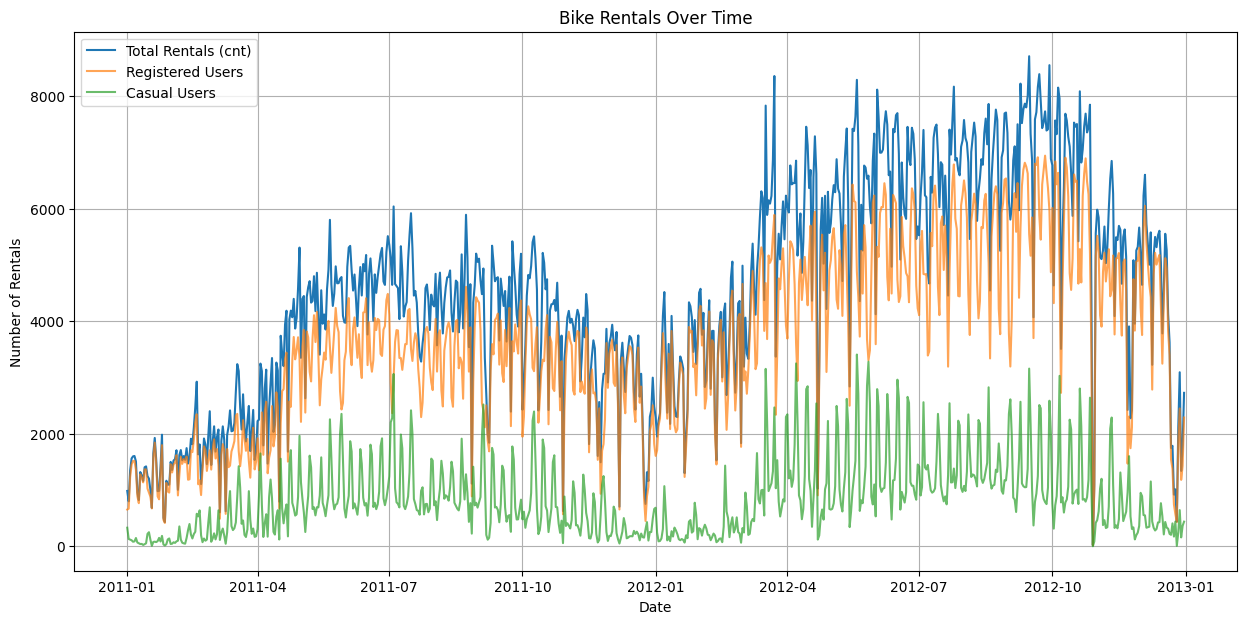

In [19]:
print("\\nPlotting counts over time:")
plt.figure(figsize=(15, 7))

pdf_sorted = pdf.sort_values(by='dteday')
plt.plot(pdf_sorted['dteday'], pdf_sorted['cnt'], label='Total Rentals (cnt)')
plt.plot(pdf_sorted['dteday'], pdf_sorted['registered'], label='Registered Users', alpha=0.7)
plt.plot(pdf_sorted['dteday'], pdf_sorted['casual'], label='Casual Users', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.title('Bike Rentals Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import unix_timestamp

def evaluate_metrics(df, metrics=['r2','rmse','mse','mae'], label_col='cnt', prediction_col='prediction'):
    """
    Funkcja oblicza metryki regresji na podstawie zbioru danych zawierającego prawdziwe wartosci etykiet
    i wartości przewidywane
    :param df: Dataset<Row> wejściowy zbiór danych
    :param metrics: lista metryk do obliczenia
    :param label_col: nazwa kolumny z wartościami wyjściowymi
    :param prediction_col: nazwa kolumny zawierającej przewidywane wartości
    :return: słownik zawierający pary (nazwa_metryki, wartość)
    """
    results = {}
    for metric in metrics:
        evaluator = RegressionEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName=metric)
        value = evaluator.evaluate(df)
        results[metric] = value
    return results

In [21]:
def train_and_test(df, feature_cols, label_col='cnt', lr=LinearRegression(maxIter=100, regParam=0.3, elasticNetParam=0.5)):
    """
    Funkcja (1) dzieli zbiór danych na df_train oraz df_test
    (2) tworzy ciąg przetwarzania zawierający VectorAssembler
    i  przekazaną jako parametr konfiguracje algorytmu regresji
    (3) buduje model i dokonuje predykcji dla df_train oraz df_test
    (4) wyświetla metryki
    :param df: wejściowy zbiór danych
    :param feature_cols: lista nazw kolumn cech
    :param label_col: nazwa kolumny docelowej
    :param lr: konfiguracja algorytmu regresji
    :return: model zwrócony przez pipeline.fit()
    """
    lr.setLabelCol(label_col)
    lr.setFeaturesCol("features")

    (df_train, df_test) = df.randomSplit([0.8, 0.2], seed=42) # Używamy seed dla powtarzalności

    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    pipeline = Pipeline(stages=[assembler, lr])

    print("Training the model...")
    model = pipeline.fit(df_train)

    print("Making predictions...")
    predictions_train = model.transform(df_train)
    predictions_test = model.transform(df_test)

    print("\nEvaluating on Training Data:")
    metrics_train = evaluate_metrics(predictions_train, label_col=label_col)
    print(f"Train: " + " ".join([f"{k}={v}" for k, v in metrics_train.items()]))

    print("\nEvaluating on Test Data:")
    metrics_test = evaluate_metrics(predictions_test, label_col=label_col)
    print(f"Test: " + " ".join([f"{k}={v}" for k, v in metrics_test.items()]))

    return model

In [22]:
df_regr = df.withColumn("unixdate", unix_timestamp(col("dteday"), "yyyy-MM-dd").cast("double"))

feature_cols = [c for c in df_regr.columns if c not in ['instant', 'dteday', 'casual', 'registered', 'cnt']]
print(f"\nFeature columns for regression: {feature_cols}")


Feature columns for regression: ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'unixdate']


In [23]:
trained_model = train_and_test(df=df_regr, feature_cols=feature_cols, label_col='cnt')

Training the model...
Making predictions...

Evaluating on Training Data:
Train: r2=0.7985861913321166 rmse=870.3795909223957 mse=757560.6322942368 mae=649.5815699383919

Evaluating on Test Data:
Test: r2=0.8023536968320716 rmse=845.5095168321028 mse=714886.3430536559 mae=638.2015318482119


In [24]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

(train_data, test_data) = df_regr.randomSplit([0.8, 0.2], seed=42)
print(f"CV Training set size: {train_data.count()}, CV Test set size: {test_data.count()}")
label_col = "cnt"

CV Training set size: 613, CV Test set size: 118


In [25]:
lr_cv = LinearRegression(labelCol=label_col, featuresCol="features")
assembler_cv = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")

pipeline_cv = Pipeline(stages=[assembler_cv, lr_cv])

paramGrid = ParamGridBuilder() \
    .addGrid(lr_cv.regParam, [0.1, 0.5, 1.0, 2.0, 3.0]) \
    .addGrid(lr_cv.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
    .build()

evaluator_cv = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse") # Domyślnie RMSE

cv = CrossValidator(estimator=pipeline_cv,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_cv,
                    numFolds=5, 
                    seed=42,
                    parallelism=2) 


In [29]:
print("Starting Cross-Validation...")
cvModel = cv.fit(train_data) 
print("Cross-Validation finished.")

Starting Cross-Validation...
Cross-Validation finished.


In [27]:
bestPipelineModel = cvModel.bestModel
bestLRModel = bestPipelineModel.stages[-1]

print("\nBest model parameters found by CV:")
print("regParam:", bestLRModel.getRegParam())
print("elasticNetParam:", bestLRModel.getElasticNetParam())

print("\nEvaluating the best model on the test set:")
predictions_test_cv = bestPipelineModel.transform(test_data)
test_metrics_cv = evaluate_metrics(predictions_test_cv, label_col=label_col, prediction_col="prediction")
print(f"Test CV: " + " ".join([f"{k}={v}" for k, v in test_metrics_cv.items()]))


Best model parameters found by CV:
regParam: 1.0
elasticNetParam: 0.75

Evaluating the best model on the test set:
Test CV: r2=0.798886238602003 rmse=852.8939755830152 mse=727428.1335858009 mae=650.6836987372918


In [30]:
def plot(df, model, label_col='cnt', prediction_col='prediction', start=0, end=-1):
    """
    Wyświetla wykres wartości rzeczywistych i przewidywanych dla modelu regresji.
    :param df: DataFrame zawierający dane do predykcji i wartości rzeczywiste.
    :param model: Wytrenowany model (PipelineModel lub model regresji).
    :param label_col: Nazwa kolumny z wartościami rzeczywistymi.
    :param prediction_col: Nazwa kolumny z wartościami przewidywanymi (po transformacji).
    :param start: Indeks początkowy zakresu do wyświetlenia.
    :param end: Indeks końcowy zakresu do wyświetlenia (-1 oznacza do końca).
    """
    count = df.count()
    if start < 0:
        start = 0
    if end == -1 or end > count:
        end = count
    if start >= end:
        print("Error: start index must be less than end index.")
        return

    print(f"Plotting results from index {start} to {end-1}")

    df_pred = model.transform(df)


    y_all = df_pred.select(label_col).rdd.flatMap(lambda r: r).collect()
    y_pred_all = df_pred.select(prediction_col).rdd.flatMap(lambda r: r).collect()

    if len(y_all) != len(y_pred_all):
         print(f"Warning: Length mismatch after collecting data: y={len(y_all)}, y_pred={len(y_pred_all)}")
         min_len = min(len(y_all), len(y_pred_all))
         y_all = y_all[:min_len]
         y_pred_all = y_pred_all[:min_len]
         if end > min_len: end = min_len
         if start >= end:
             print("Error: start index exceeds available data length after potential mismatch adjustments.")
             return


    y_range = y_all[start:end]
    y_pred_range = y_pred_all[start:end]
    x = np.arange(start, end) 

    plt.figure(figsize=(15, 6))
    plt.plot(x, y_range, label=f'True ({label_col})')
    plt.plot(x, y_pred_range, label=f'Predicted ({prediction_col})', alpha=0.7)
    plt.legend()
    try:
        model_name = model.stages[-1].__class__.__name__
    except AttributeError: 
        model_name = model.__class__.__name__
    plt.title(f'{model_name} - True vs Predicted (Indices {start}-{end-1})')
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

Plotting results from index 0 to 49


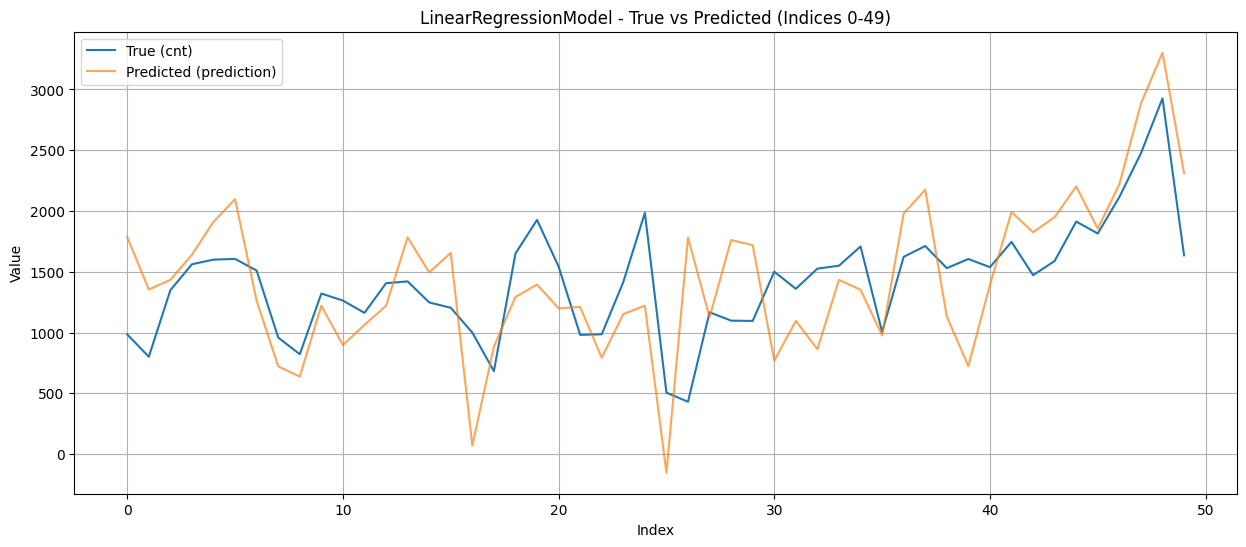

Plotting results from index 100 to 149


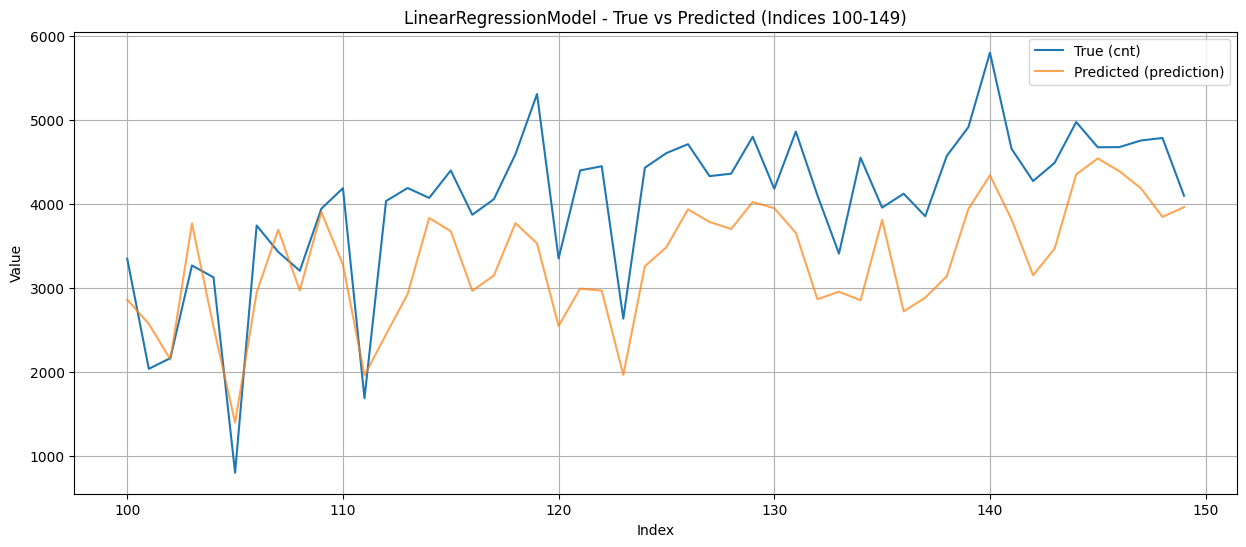

Plotting results from index 0 to 730


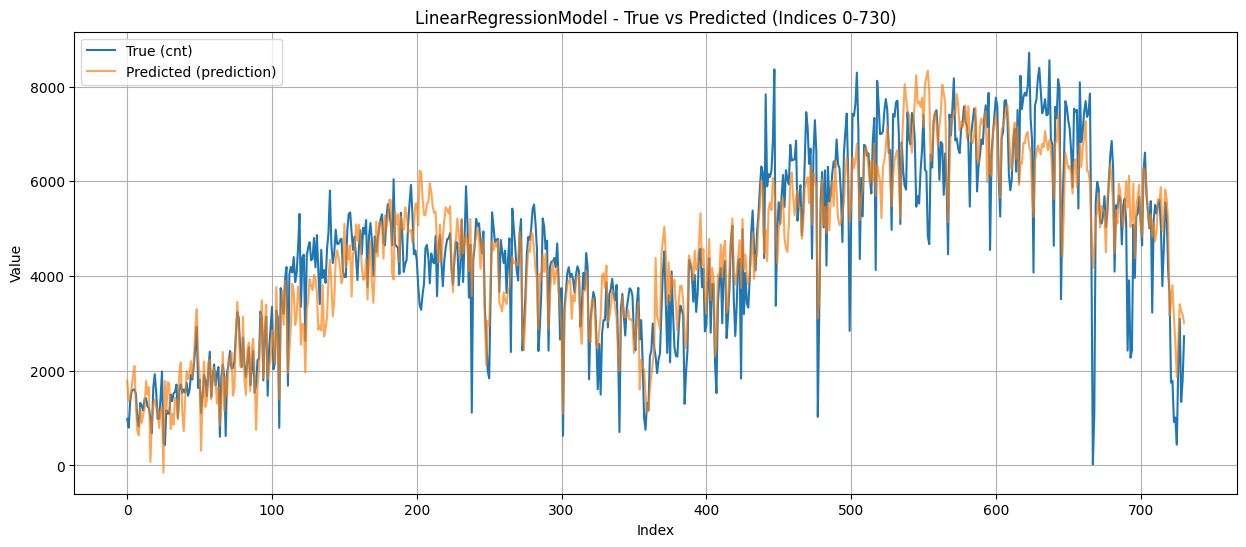

In [31]:
plot(df=df_regr, model=bestPipelineModel, start=0, end=50) # Pierwsze 50 punktów
plot(df=df_regr, model=bestPipelineModel, start=100, end=150) # Zakres w środku
plot(df=df_regr, model=bestPipelineModel) # Cały zbiór (może być nieczytelny)

In [32]:
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor, GBTRegressor

best_lr = LinearRegression(
    maxIter=100, 
    regParam=bestLRModel.getRegParam(),
    elasticNetParam=bestLRModel.getElasticNetParam(),
    labelCol=label_col,
    featuresCol="features"
)

dt = DecisionTreeRegressor(labelCol=label_col, featuresCol="features")
rf = RandomForestRegressor(labelCol=label_col, featuresCol="features", seed=42)
gbt = GBTRegressor(labelCol=label_col, featuresCol="features", seed=42)

regressors = [best_lr, dt, rf, gbt]

results = {}
trained_models = {}

print("Defined regressors to compare:", [r.__class__.__name__ for r in regressors])

Defined regressors to compare: ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'GBTRegressor']


In [35]:
assembler_comp = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")

for regressor in regressors:
    model_name = regressor.__class__.__name__
    print(f"\n--- Training and Evaluating {model_name} ---")

    pipeline = Pipeline(stages=[assembler_comp, regressor])

    try:
        model = pipeline.fit(train_data)
        print(f"Finished training {model_name}.")

        print(f"Making predictions with {model_name} on test data...")
        predictions = model.transform(test_data)

        prediction_col_name = regressor.getPredictionCol()
        metrics = evaluate_metrics(predictions, label_col=label_col, prediction_col=prediction_col_name)
        print(f"Test Metrics ({model_name}): " + " ".join([f"\n{k}={v}" for k, v in metrics.items()]))

        results[model_name] = metrics
        trained_models[model_name] = model 

    except Exception as e:
        print(f"ERROR training/evaluating {model_name}: {e}")
        results[model_name] = None 
        trained_models[model_name] = None


--- Training and Evaluating LinearRegression ---
Finished training LinearRegression.
Making predictions with LinearRegression on test data...
Test Metrics (LinearRegression): 
r2=0.798886238602003 
rmse=852.8939755830152 
mse=727428.1335858009 
mae=650.6836987372918

--- Training and Evaluating DecisionTreeRegressor ---
Finished training DecisionTreeRegressor.
Making predictions with DecisionTreeRegressor on test data...
Test Metrics (DecisionTreeRegressor): 
r2=0.7569718750354462 
rmse=937.5672324992886 
mse=879032.315456375 
mae=634.2722057055026

--- Training and Evaluating RandomForestRegressor ---
Finished training RandomForestRegressor.
Making predictions with RandomForestRegressor on test data...
Test Metrics (RandomForestRegressor): 
r2=0.848587388928303 
rmse=740.0399700173717 
mse=547659.1572233124 
mae=539.6079381534458

--- Training and Evaluating GBTRegressor ---
Finished training GBTRegressor.
Making predictions with GBTRegressor on test data...
Test Metrics (GBTRegresso

In [39]:
best_r2 = -float('inf')
best_model_name = None
best_model_pipeline = None

for name, metrics in results.items():
    if metrics and 'r2' in metrics:
        print(f"Model: {name}, Test R2: {metrics['r2']}")
        if metrics['r2'] > best_r2:
            best_r2 = metrics['r2']
            best_model_name = name
            best_model_pipeline = trained_models[name] 
    elif name in trained_models: 
         print(f"Model: {name}, Evaluation failed or R2 not available.")

print(f"\nBest algorithm found: {best_model_name} (Test R2 = {best_r2})")

Model: LinearRegression, Test R2: 0.798886238602003
Model: DecisionTreeRegressor, Test R2: 0.7569718750354462
Model: RandomForestRegressor, Test R2: 0.848587388928303
Model: GBTRegressor, Test R2: 0.7613027898409288

Best algorithm found: RandomForestRegressor (Test R2 = 0.848587388928303)



--- Plotting results for the best model: RandomForestRegressor ---

Plotting first 100 points of the test set:
Plotting results from index 0 to 99


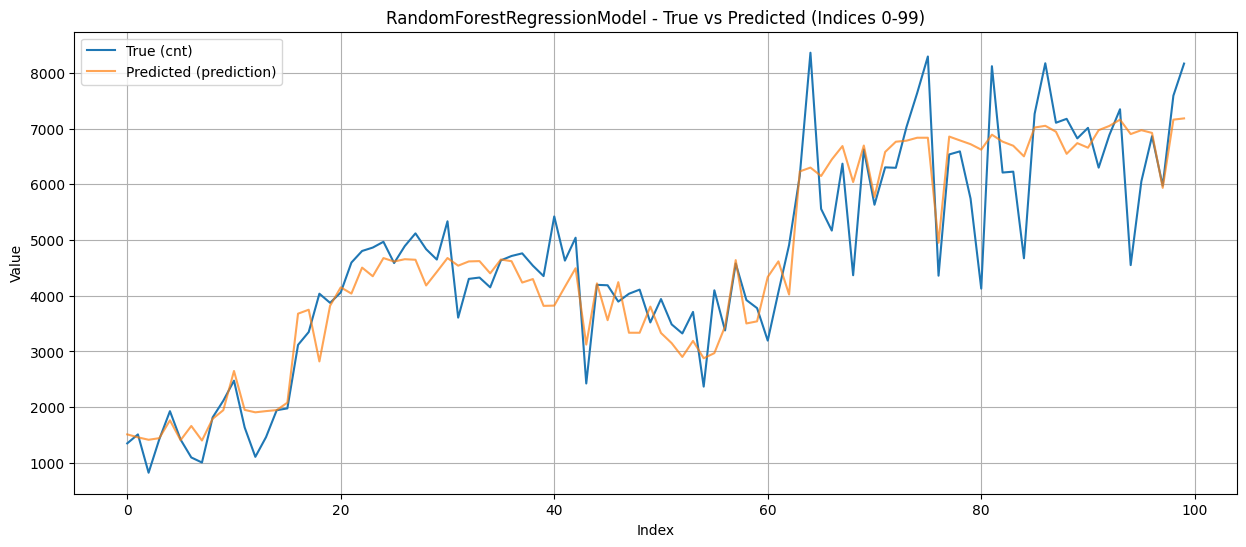


Plotting all points of the test set (may be slow/unclear):
Plotting results from index 0 to 117


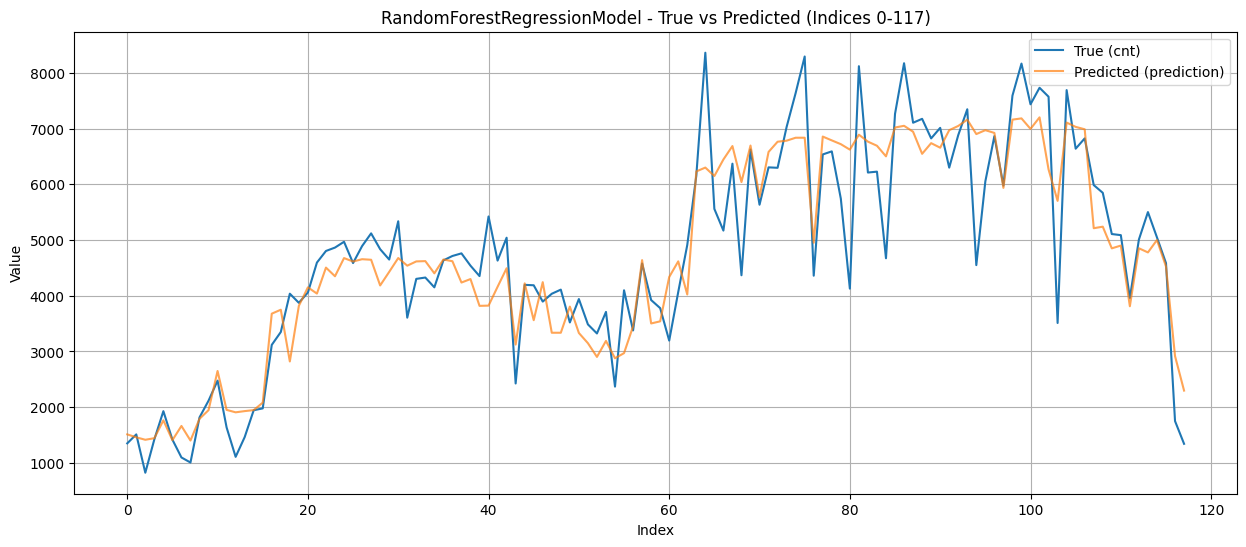

In [40]:
print(f"\n--- Plotting results for the best model: {best_model_name} ---")
try:
    best_regressor_stage = best_model_pipeline.stages[-1]
    prediction_col_name_best = best_regressor_stage.getPredictionCol()

    print("\nPlotting first 100 points of the test set:")
    plot(df=test_data, model=best_model_pipeline, label_col=label_col, prediction_col=prediction_col_name_best, start=0, end=100)

    print("\nPlotting all points of the test set (may be slow/unclear):")
    plot(df=test_data, model=best_model_pipeline, label_col=label_col, prediction_col=prediction_col_name_best)
except NameError:
    print("ERROR: The 'plot' function is not defined. Please ensure it was defined in a previous cell.")
except Exception as e:
        print(f"An error occurred during plotting: {e}")


In [42]:
print(f"\n--- Calculating Pearson Correlation with '{label_col}' ---")
correlations = {}
for col_name in feature_cols:
    col_type = df_regr .schema[col_name].dataType
    if isinstance(col_type, (pyspark.sql.types.NumericType, pyspark.sql.types.DoubleType, pyspark.sql.types.IntegerType, pyspark.sql.types.FloatType, pyspark.sql.types.LongType, pyspark.sql.types.ShortType, pyspark.sql.types.ByteType)):
            correlation = df_regr .stat.corr(col_name, label_col)
            correlations[col_name] = correlation
            print(f"Correlation between '{col_name}' and '{label_col}': {correlation:.4f}")
    else:
        print(f"Skipping correlation for non-numeric column '{col_name}' (Type: {col_type})")
        correlations[col_name] = None 
    


--- Calculating Pearson Correlation with 'cnt' ---
Correlation between 'season' and 'cnt': 0.4061
Correlation between 'yr' and 'cnt': 0.5667
Correlation between 'mnth' and 'cnt': 0.2800
Correlation between 'holiday' and 'cnt': -0.0683
Correlation between 'weekday' and 'cnt': 0.0674
Correlation between 'workingday' and 'cnt': 0.0612
Correlation between 'weathersit' and 'cnt': -0.2974
Correlation between 'temp' and 'cnt': 0.6275
Correlation between 'atemp' and 'cnt': 0.6311
Correlation between 'hum' and 'cnt': -0.1007
Correlation between 'windspeed' and 'cnt': -0.2345
Correlation between 'unixdate' and 'cnt': 0.6288



--- Generating Scatter Plots (using 30.0% sample) ---
Sample size for plotting: 232 rows


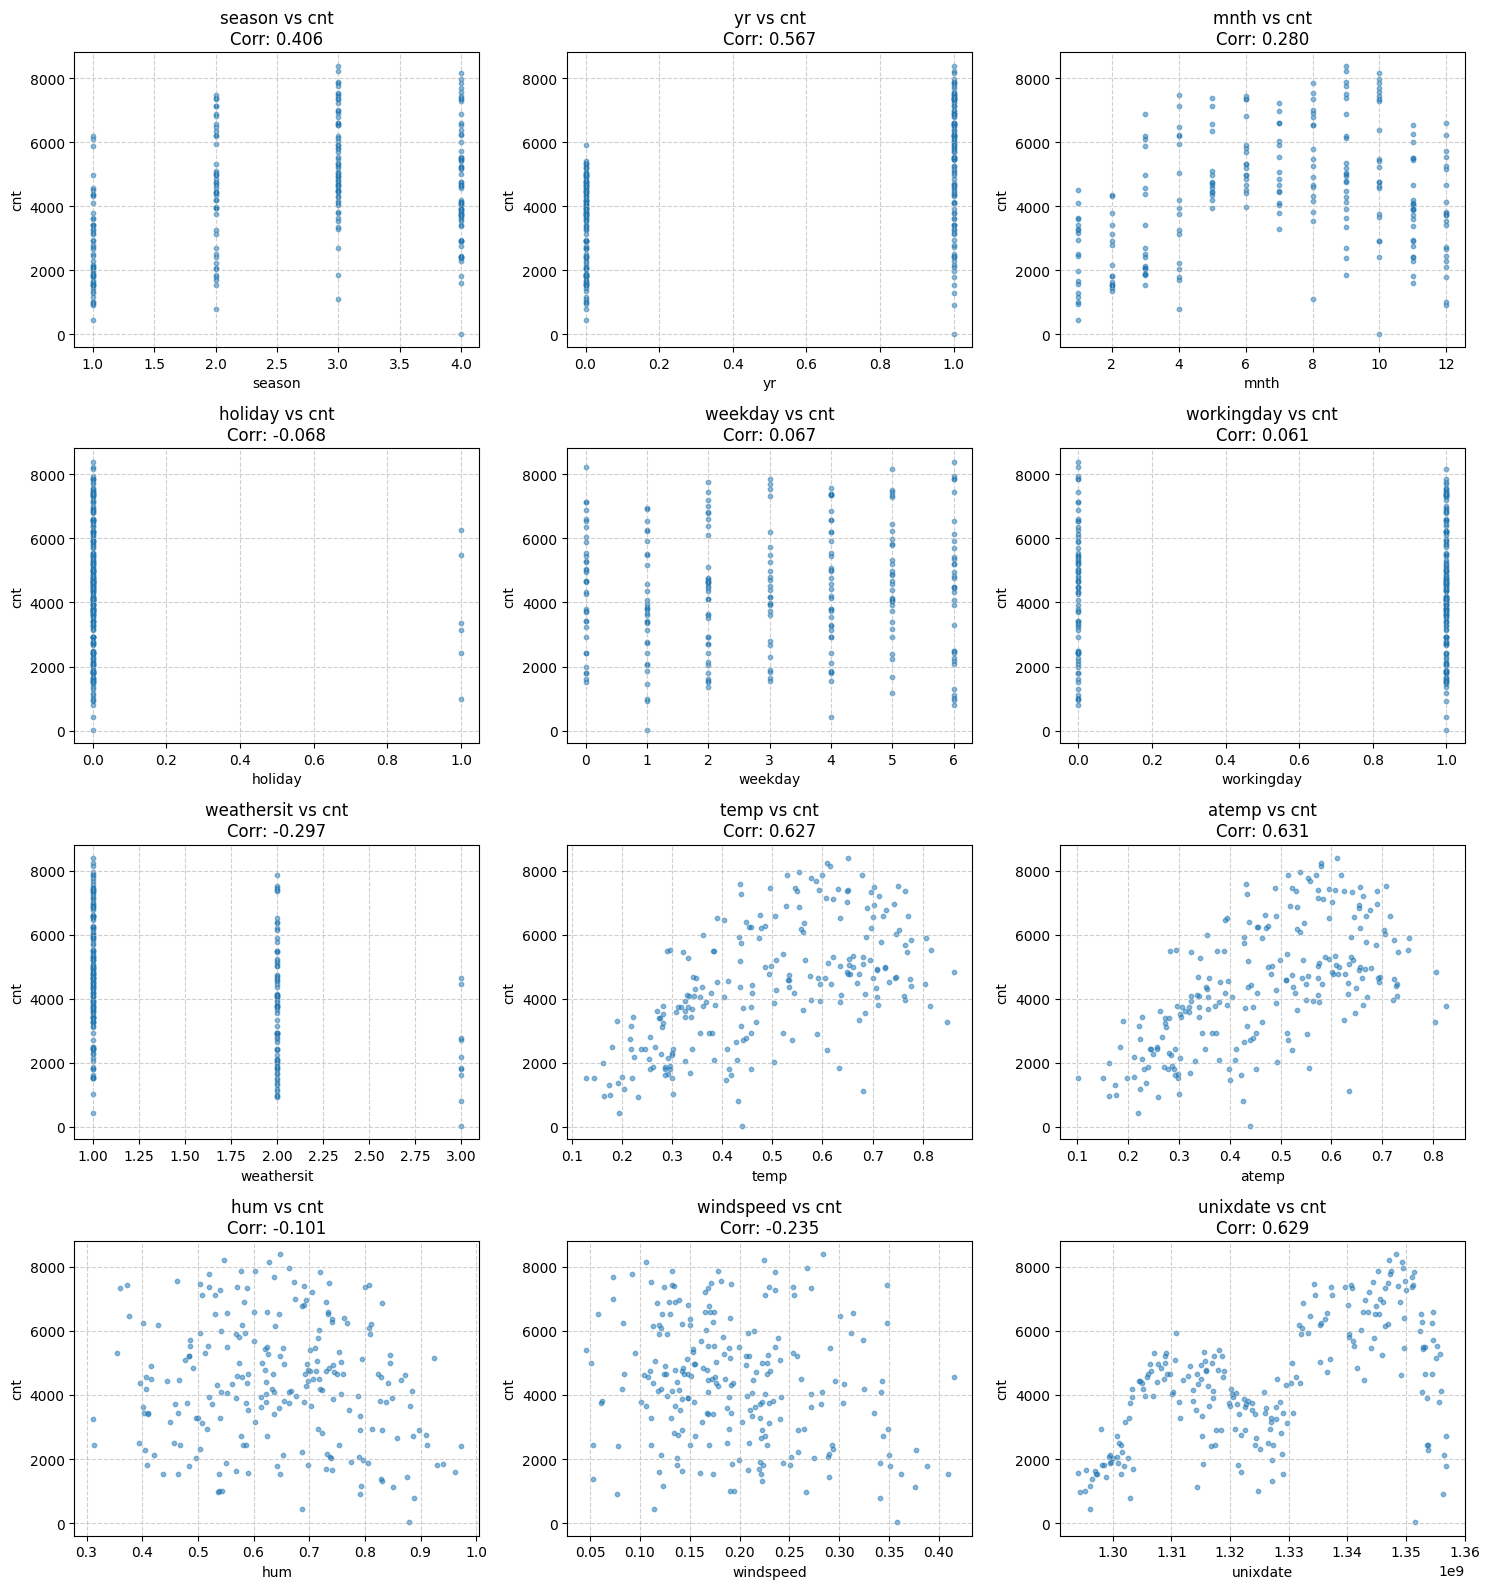

In [44]:
sample_fraction = 0.3
seed = 42
print(f"\n--- Generating Scatter Plots (using {sample_fraction*100}% sample) ---")

sample_pdf = df_regr .select(feature_cols + [label_col]).sample(fraction=sample_fraction, seed=seed).toPandas()
print(f"Sample size for plotting: {len(sample_pdf)} rows")

if sample_pdf.empty:
    print("WARN: Sampled DataFrame is empty. Cannot generate plots.")
else:
    num_features = len(feature_cols)
    cols_plot = 3 
    rows_plot = int(np.ceil(num_features / cols_plot))

    plt.figure(figsize=(cols_plot * 5, rows_plot * 4)) 

    for i, col_name in enumerate(feature_cols):
        plt.subplot(rows_plot, cols_plot, i + 1)
        if col_name in sample_pdf.columns:
                plt.scatter(sample_pdf[col_name], sample_pdf[label_col], alpha=0.5, s=10) 
                plt.xlabel(col_name)
                plt.ylabel(label_col)
                corr_val = correlations.get(col_name)
                title = f"{col_name} vs {label_col}"
                if corr_val is not None:
                    title += f"\nCorr: {corr_val:.3f}"
                plt.title(title)
                plt.grid(True, linestyle='--', alpha=0.6)
        else:
                plt.title(f"{col_name} - Error (column not in sample?)")
                print(f"Column {col_name} not found in the sampled Pandas DataFrame.")


    plt.tight_layout()
    plt.show()


In [45]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

if 'df_regr' not in locals():
     print("ERROR: DataFrame 'df_regr' not found. Please run previous cells.")
     raise NameError("DataFrame 'df_regr' is not defined")

print("\n--- Demonstrating StringIndexer + OneHotEncoder on 'weekday' ---")

indexer = StringIndexer(inputCol="weekday", outputCol="weekdayIndex", handleInvalid="keep")
encoder = OneHotEncoder(inputCol="weekdayIndex", outputCol="weekdayVec")

pipeline_demo = Pipeline(stages=[indexer, encoder])

model_demo = pipeline_demo.fit(df_regr)
df_encoded_demo = model_demo.transform(df_regr)

df_encoded_demo.select("weekday", "weekdayIndex", "weekdayVec").show(5, truncate=False)

first_vector = df_encoded_demo.select("weekdayVec").first()
if first_vector:
    print(f"Length of 'weekdayVec' (k-1 encoding): {first_vector.weekdayVec.size}")


--- Demonstrating StringIndexer + OneHotEncoder on 'weekday' ---
+-------+------------+-------------+
|weekday|weekdayIndex|weekdayVec   |
+-------+------------+-------------+
|6      |2.0         |(7,[2],[1.0])|
|0      |0.0         |(7,[0],[1.0])|
|1      |1.0         |(7,[1],[1.0])|
|2      |3.0         |(7,[3],[1.0])|
|3      |4.0         |(7,[4],[1.0])|
+-------+------------+-------------+
only showing top 5 rows

Length of 'weekdayVec' (k-1 encoding): 7


In [46]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

def encode_one_hot(df, col_name):
    index_col = f"{col_name}_Index"
    vec_col = f"{col_name}_Vec"

    indexer = StringIndexer(inputCol=col_name, outputCol=index_col, handleInvalid="keep")
    encoder = OneHotEncoder(inputCol=index_col, outputCol=vec_col, dropLast=True)

    pipeline = Pipeline(stages=[indexer, encoder])

    print(f"Applying OneHotEncoding to column: '{col_name}' -> '{vec_col}'")
    model = pipeline.fit(df)
    df_transformed = model.transform(df)

    return df_transformed

In [47]:
cols_to_encode = ['season', 'mnth', 'weekday', 'weathersit']
df_ohe = df_regr

print("\n--- Applying OneHotEncoding to specified columns ---")
for col in cols_to_encode:
    if col in df_ohe.columns:
         df_ohe = encode_one_hot(df_ohe, col)
    else:
         print(f"Warning: Column '{col}' not found in DataFrame. Skipping OHE.")

print("\nSchema after OneHotEncoding:")
df_ohe.printSchema()
df_ohe.select(['season', 'season_Index', 'season_Vec', 'mnth', 'mnth_Index', 'mnth_Vec']).show(5, truncate=False)



--- Applying OneHotEncoding to specified columns ---
Applying OneHotEncoding to column: 'season' -> 'season_Vec'
Applying OneHotEncoding to column: 'mnth' -> 'mnth_Vec'
Applying OneHotEncoding to column: 'weekday' -> 'weekday_Vec'
Applying OneHotEncoding to column: 'weathersit' -> 'weathersit_Vec'

Schema after OneHotEncoding:
root
 |-- instant: integer (nullable = true)
 |-- dteday: date (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)
 |-- unixdate: double (nullable = true)
 |-- 

In [50]:
from pyspark.sql.functions import col, pow as spark_pow

cols_for_poly = ['temp', 'hum', 'windspeed', 'unixdate']
degree = 2

df_poly = df_ohe 

print(f"\n--- Adding Polynomial Features (degree={degree}) ---")
for col_name in cols_for_poly:
    if col_name in df_poly.columns:
        poly_col_name = f"{col_name}_sq"
        print(f"Adding: {poly_col_name}")
        df_poly = df_poly.withColumn(poly_col_name, spark_pow(col(col_name), degree))
    else:
        print(f"Warning: Column '{col_name}' not found for polynomial feature generation.")

if 'atemp' in df_poly.columns:
    print("Dropping column: 'atemp'")
    df_poly = df_poly.drop('atemp')

print("\nSchema after adding polynomial features:")
df_poly.printSchema()
df_poly.select('temp', 'temp_sq', 'hum', 'hum_sq').show(5)



--- Adding Polynomial Features (degree=2) ---
Adding: temp_sq
Adding: hum_sq
Adding: windspeed_sq
Adding: unixdate_sq
Dropping column: 'atemp'

Schema after adding polynomial features:
root
 |-- instant: integer (nullable = true)
 |-- dteday: date (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)
 |-- unixdate: double (nullable = true)
 |-- season_Index: double (nullable = false)
 |-- season_Vec: vector (nullable = true)
 |-- mnth_Index: double (nullable = false)
 |-- mnth_Vec: vector (nullable = true)
 |-- weekday_Ind

In [51]:
numeric_binary_cols = ['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'unixdate']
poly_cols = [f"{c}_sq" for c in cols_for_poly]
ohe_cols = [f"{c}_Vec" for c in cols_to_encode]

final_feature_cols = [c for c in (numeric_binary_cols + poly_cols + ohe_cols) if c in df_poly.columns]

print(f"\nFinal feature columns for VectorAssembler: {final_feature_cols}")

select_cols = final_feature_cols + [label_col]
df_final_selected = df_poly.select(select_cols)
df_final_cleaned = df_final_selected.dropna()

print(f"Original size before final clean: {df_poly.count()}, Size after final clean: {df_final_cleaned.count()}")

(train_data_final, test_data_final) = df_final_cleaned.randomSplit([0.8, 0.2], seed=42)
print(f"Final Training set size: {train_data_final.count()}, Final Test set size: {test_data_final.count()}")



Final feature columns for VectorAssembler: ['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'unixdate', 'temp_sq', 'hum_sq', 'windspeed_sq', 'unixdate_sq', 'season_Vec', 'mnth_Vec', 'weekday_Vec', 'weathersit_Vec']
Original size before final clean: 731, Size after final clean: 731
Final Training set size: 613, Final Test set size: 118



--- Testing LinearRegression with new features ---
Using LinearRegression with best CV params: regParam=1.0, elasticNetParam=0.75

Test Metrics (LinearRegression with Preprocessing): r2=0.8970491699477106 rmse=615.2275265183478 mse=378504.90938588436 mae=483.8875895125228

Plotting results for LinearRegression with new features (Test Data):
Plotting results from index 0 to 99


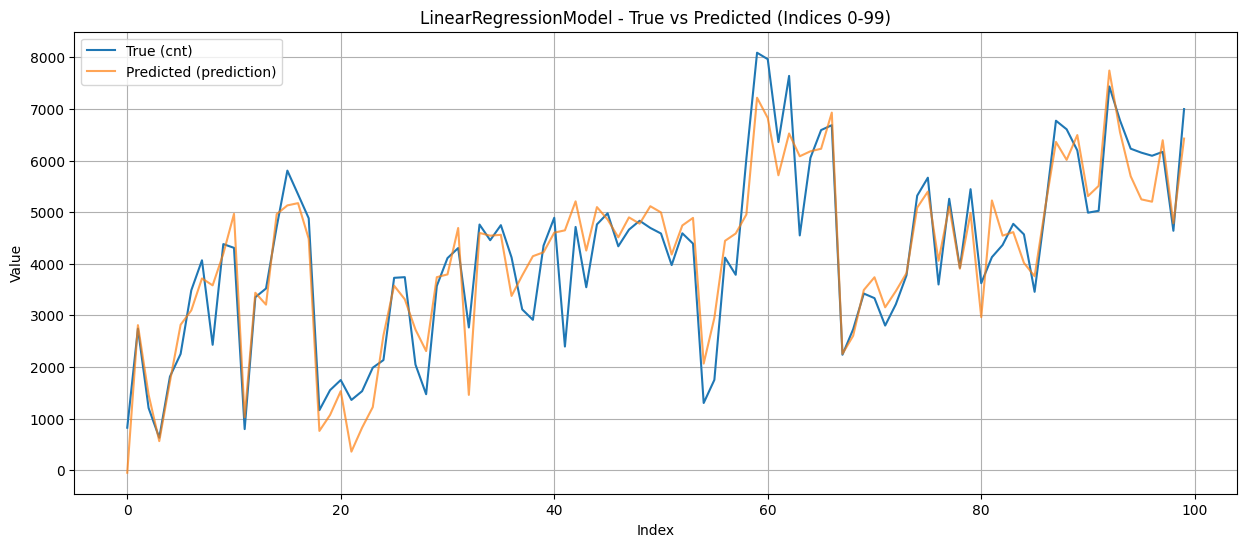

Plotting results from index 0 to 117


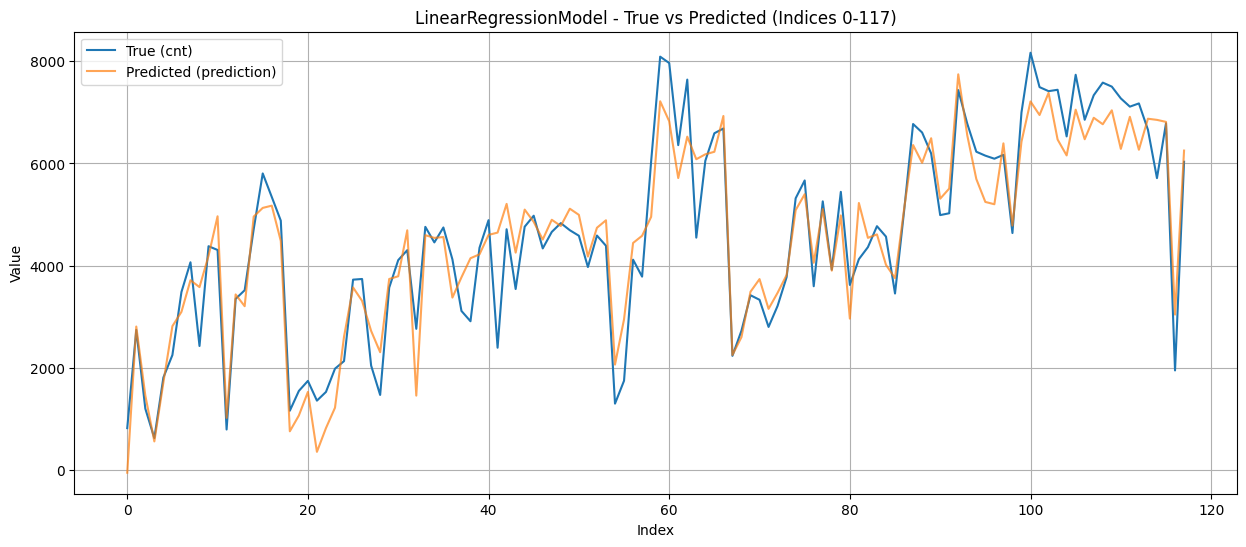

In [53]:
from pyspark.ml.feature import VectorAssembler

print("\n--- Testing LinearRegression with new features ---")

if 'bestLRModel' in locals():
    lr_final = LinearRegression(
        maxIter=100,
        regParam=bestLRModel.getRegParam(),
        elasticNetParam=bestLRModel.getElasticNetParam(),
        labelCol=label_col,
        featuresCol="features"
    )
    print(f"Using LinearRegression with best CV params: regParam={bestLRModel.getRegParam()}, elasticNetParam={bestLRModel.getElasticNetParam()}")
else:
    print("Warning: Best LR parameters from CV not found. Using default LinearRegression.")
    lr_final = LinearRegression(labelCol=label_col, featuresCol="features")

assembler_final = VectorAssembler(inputCols=final_feature_cols, outputCol="features", handleInvalid="keep")

pipeline_final_lr = Pipeline(stages=[assembler_final, lr_final])

model_final_lr = pipeline_final_lr.fit(train_data_final)

predictions_final_lr = model_final_lr.transform(test_data_final)
metrics_final_lr = evaluate_metrics(predictions_final_lr, label_col=label_col, prediction_col=lr_final.getPredictionCol())
print(f"\nTest Metrics (LinearRegression with Preprocessing): " + " ".join([f"{k}={v}" for k, v in metrics_final_lr.items()]))

print("\nPlotting results for LinearRegression with new features (Test Data):")
plot(df=test_data_final, model=model_final_lr, label_col=label_col, prediction_col=lr_final.getPredictionCol(), start=0, end=100)
plot(df=test_data_final, model=model_final_lr, label_col=label_col, prediction_col=lr_final.getPredictionCol())

In [57]:
dt_final = DecisionTreeRegressor(labelCol=label_col, featuresCol="features")
rf_final = RandomForestRegressor(labelCol=label_col, featuresCol="features", seed=42)
gbt_final = GBTRegressor(labelCol=label_col, featuresCol="features", seed=42)

other_regressors = [dt_final, rf_final, gbt_final]
final_results = { }
final_models = { }

assembler_final = VectorAssembler(inputCols=final_feature_cols, outputCol="features", handleInvalid="keep")

print("\n--- Testing Other Regression Algorithms with new features ---")

for regressor in other_regressors:
    model_name = regressor.__class__.__name__
    print(f"\n--- Training and Evaluating {model_name} ---")

    pipeline = Pipeline(stages=[assembler_final, regressor])

    model = pipeline.fit(train_data_final)
    predictions = model.transform(test_data_final)
    metrics = evaluate_metrics(predictions, label_col=label_col, prediction_col=regressor.getPredictionCol())
    print(f"Test Metrics ({model_name} with Preprocessing): " + " ".join([f"{k}={v}" for k, v in metrics.items()]))
    final_results[model_name] = metrics
    final_models[model_name] = model
    

best_r2_final = -float('inf')
best_model_name_final = None
best_model_pipeline_final = None

print("\n--- Determining Best Model after Preprocessing (based on Test R2) ---")
for name, metrics in final_results.items():
    print(f"Model: {name}, Test R2: {metrics['r2']}")
    if metrics['r2'] > best_r2_final:
        best_r2_final = metrics['r2']
        best_model_name_final = name
        best_model_pipeline_final = final_models[name]


--- Testing Other Regression Algorithms with new features ---

--- Training and Evaluating DecisionTreeRegressor ---
Test Metrics (DecisionTreeRegressor with Preprocessing): r2=0.8320515111291114 rmse=785.794314982215 mse=617472.7054583686 mae=586.1874013246324

--- Training and Evaluating RandomForestRegressor ---
Test Metrics (RandomForestRegressor with Preprocessing): r2=0.8860582625105644 rmse=647.235382713323 mse=418913.6406360618 mae=494.7601374181607

--- Training and Evaluating GBTRegressor ---
Test Metrics (GBTRegressor with Preprocessing): r2=0.8619858791406823 rmse=712.3322284996449 mse=507417.2037592704 mae=507.7101987840227

--- Determining Best Model after Preprocessing (based on Test R2) ---
Model: DecisionTreeRegressor, Test R2: 0.8320515111291114
Model: RandomForestRegressor, Test R2: 0.8860582625105644
Model: GBTRegressor, Test R2: 0.8619858791406823



Best algorithm after preprocessing: RandomForestRegressor (Test R2 = 0.8860582625105644)

Plotting results for the best model after preprocessing: RandomForestRegressor
Plotting results from index 0 to 99


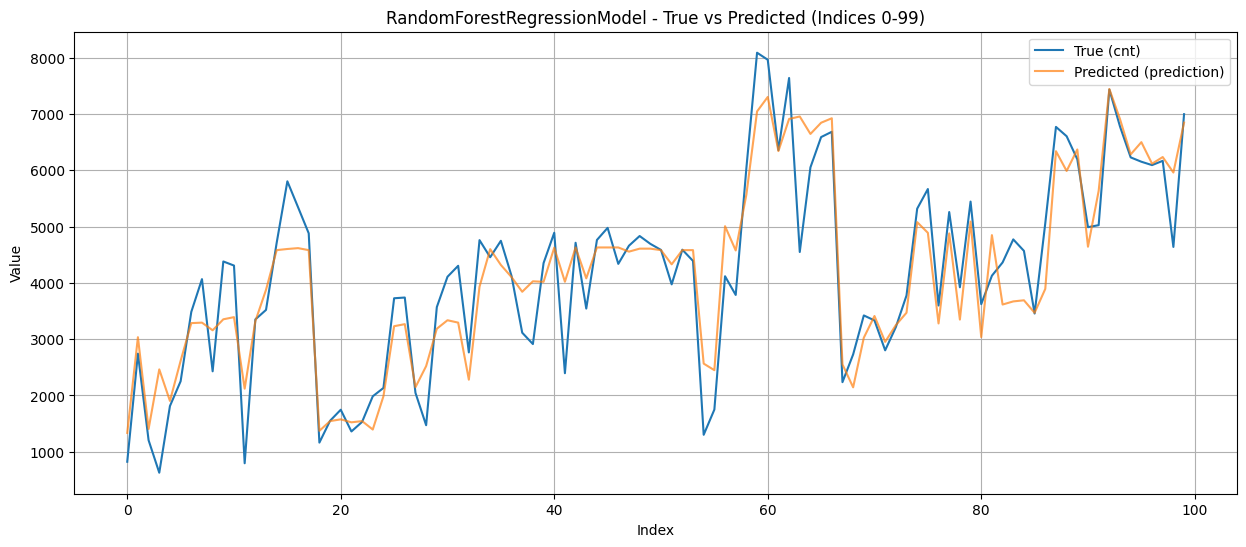

Plotting results from index 0 to 117


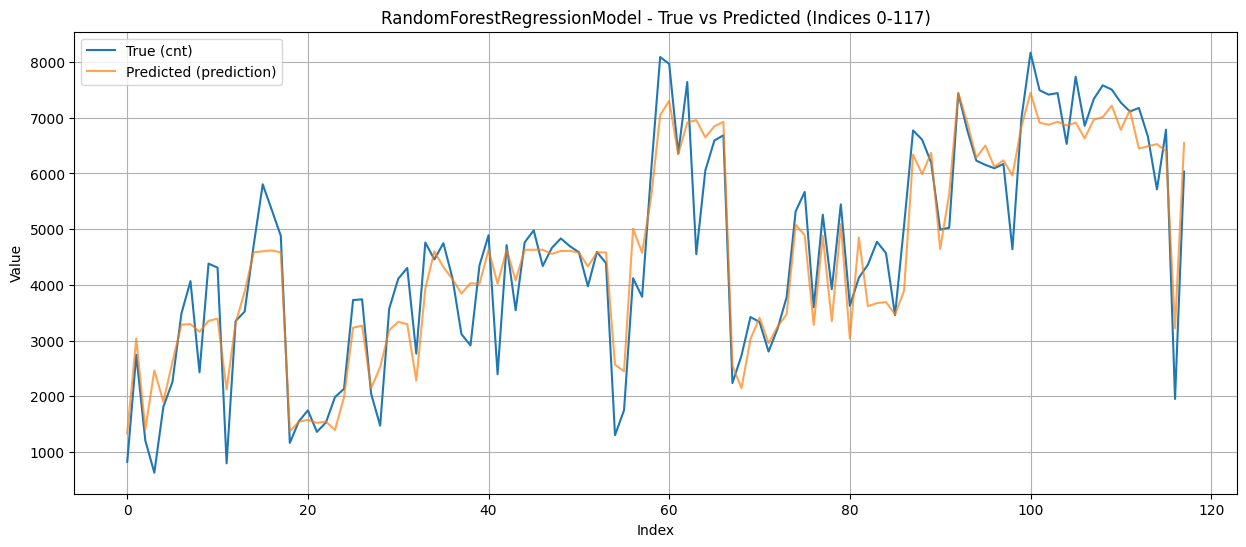

In [58]:
print(f"\nBest algorithm after preprocessing: {best_model_name_final} (Test R2 = {best_r2_final})")

print(f"\nPlotting results for the best model after preprocessing: {best_model_name_final}")
best_regressor_stage_final = best_model_pipeline_final.stages[-1]
prediction_col_name_best_final = best_regressor_stage_final.getPredictionCol()
plot(df=test_data_final, model=best_model_pipeline_final, label_col=label_col, prediction_col=prediction_col_name_best_final, start=0, end=100)
plot(df=test_data_final, model=best_model_pipeline_final, label_col=label_col, prediction_col=prediction_col_name_best_final)


In [79]:
from pyspark.ml.feature import PolynomialExpansion, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

def train_polynomial_features(df, input_col='instant', label_col='cnt', lr=LinearRegression(), degree=2):
    """
    Funkcja przetwarza cały zbiór danych
    (1) tworzy ciag przetwarzania zawierający VectorAssembler
    z jedynym wejściowym atrybutem input_col, dalej PolynomialExpansion
    i  przekazaną jako parametr konfiguracje algorytmu regresji
    (2) buduje model i dokonuje predykcji dla df
    (3) wyświetla metryki za pomocą funkcji evaluate_metrics()
    :param df: wejściowy zbiór danych (powinien zawierać input_col i label_col)
    :param input_col: nazwa kolumny wejściowej dla trendu (np. 'instant')
    :param label_col: nazwa kolumny docelowej (np. 'cnt')
    :param lr: konfiguracja algorytmu regresji
    :param degree: stopień wielomianu (argument PolynomialExpansion)
    :return: model zwrócony przez pipeline.fit()
    """
    if not isinstance(df.schema[input_col].dataType, (pyspark.sql.types.NumericType)):
        print(f"Warning: Input column '{input_col}' is not numeric. Casting to double.")
        df = df.withColumn(input_col, col(input_col).cast("double"))

    required_cols = [input_col, label_col]
    df_cleaned = df.select(required_cols).dropna()
    original_count = df.count()
    cleaned_count = df_cleaned.count()
    if original_count != cleaned_count:
        print(f"Warning: Removed {original_count - cleaned_count} rows with null values in '{input_col}' or '{label_col}'.")

    lr.setLabelCol(label_col)
    lr.setFeaturesCol("polyFeatures")

    assembler = VectorAssembler(inputCols=[input_col], outputCol="features_vec", handleInvalid="skip")
    polyExpansion = PolynomialExpansion(degree=degree, inputCol="features_vec", outputCol="polyFeatures")
    pipeline = Pipeline(stages=[assembler, polyExpansion, lr])

    print(f"\n--- Training Polynomial Regression (degree={degree}) ---")
    print(f"LR Params: maxIter={lr.getMaxIter()}, regParam={lr.getRegParam()}, elasticNetParam={lr.getElasticNetParam()}")

    model = pipeline.fit(df_cleaned)
    predictions = model.transform(df_cleaned)

    print("Evaluating on the entire dataset:")
    metrics = evaluate_metrics(predictions, label_col=label_col, prediction_col=lr.getPredictionCol())
    print(f"Metrics: " + " ".join([f"{k}={v}" for k, v in metrics.items()]))

    return model



Experiment 1: Degree=2, regParam=0.01, elasticNetParam=0, maxIter=10

--- Training Polynomial Regression (degree=2) ---
LR Params: maxIter=10, regParam=0.01, elasticNetParam=0.0
Evaluating on the entire dataset:
Metrics: r2=0.4269813593465823 rmse=1465.4268490889165 mse=2147475.85003067 mae=1173.8770856773638
Plotting results from index 0 to 730


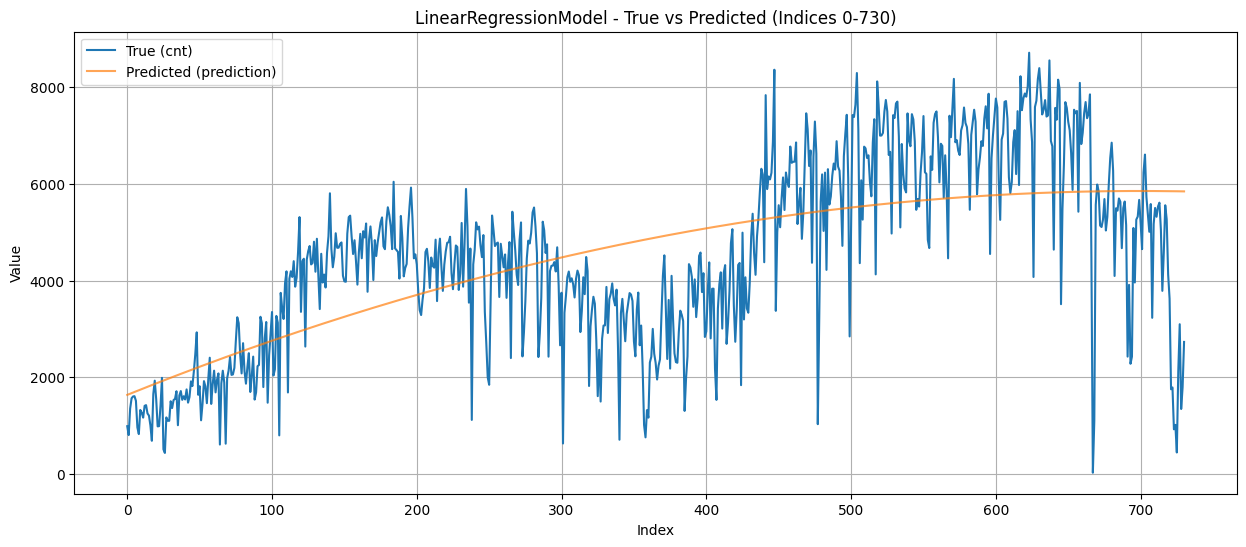


Experiment 2: Degree=3, regParam=0.01, elasticNetParam=1, maxIter=1000

--- Training Polynomial Regression (degree=3) ---
LR Params: maxIter=1000, regParam=0.01, elasticNetParam=1.0
Evaluating on the entire dataset:
Metrics: r2=0.4364768062951765 rmse=1453.234391335639 mse=2111890.196160665 mae=1181.2982451372782
Plotting results from index 0 to 730


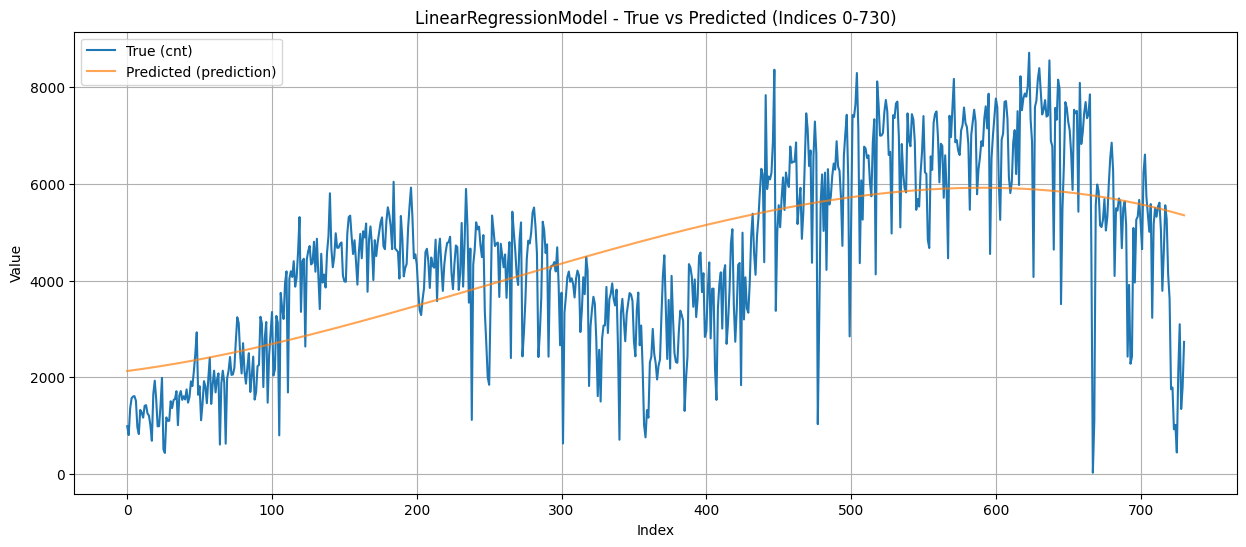


Experiment 3: Degree=4, regParam=0.001, elasticNetParam=0, maxIter=1000

--- Training Polynomial Regression (degree=4) ---
LR Params: maxIter=1000, regParam=0.001, elasticNetParam=0.0
Evaluating on the entire dataset:
Metrics: r2=0.6723622127341335 rmse=1108.09440326539 mse=1227873.2065480808 mae=858.4113436577304
Plotting results from index 0 to 730


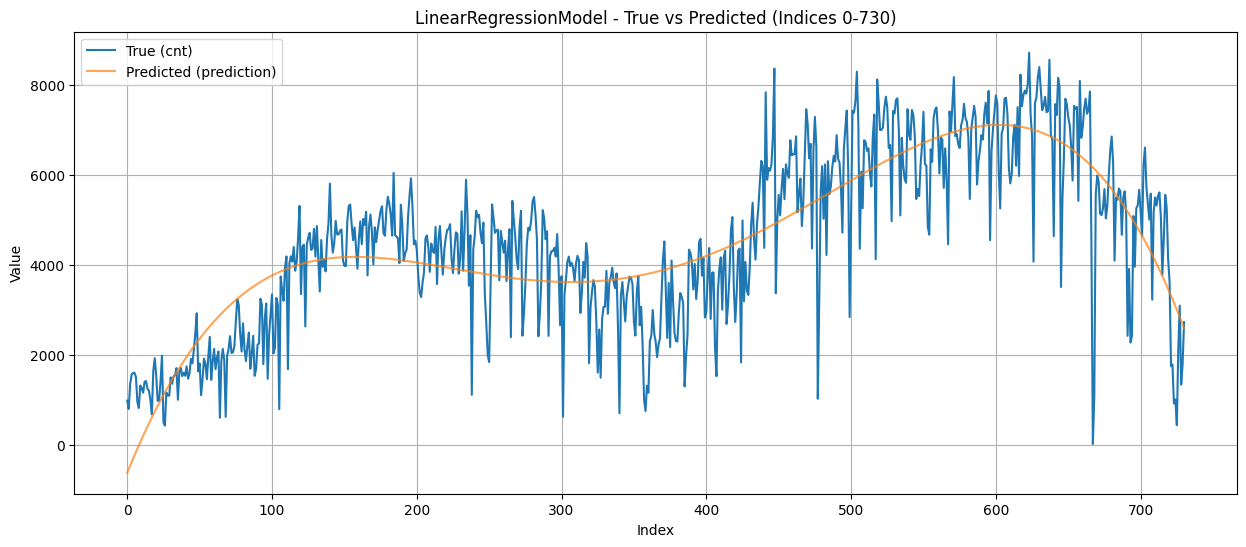

In [83]:
# --- Eksperymenty ---

# Przykład 1: Stopień 2, mała regularyzacja, Ridge (elasticNetParam=0), mało iteracji
print("\nExperiment 1: Degree=2, regParam=0.01, elasticNetParam=0, maxIter=10")
model1 = train_polynomial_features(
    df,
    lr=LinearRegression(maxIter=10, regParam=0.01, elasticNetParam=0.0),
    degree=2
)
plot(df.orderBy('instant'), model1, label_col='cnt', prediction_col='prediction') # Sortuj wg instant dla wykresu!

# Przykład 2: Stopień 3, mała regularyzacja, Lasso (elasticNetParam=1), dużo iteracji
print("\nExperiment 2: Degree=3, regParam=0.01, elasticNetParam=1, maxIter=1000")
model2 = train_polynomial_features(
    df,
    lr=LinearRegression(maxIter=1000, regParam=0.01, elasticNetParam=1.0),
    degree=3
)
plot(df.orderBy('instant'), model2, label_col='cnt', prediction_col='prediction')

# Przykład 3: Wyższy stopień (np. 4), bardzo mała regularyzacja, Ridge, dużo iteracji
print("\nExperiment 3: Degree=4, regParam=0.001, elasticNetParam=0, maxIter=1000")
model3 = train_polynomial_features(
    df,
    lr=LinearRegression(maxIter=1000, regParam=0.001, elasticNetParam=0.0),
    degree=4
)
plot(df.orderBy('instant'), model3, label_col='cnt', prediction_col='prediction')


--- Details for Chosen Trend Model (Experiment 3) ---
Coefficients: [80.50560474248067,-0.4511896751227687,0.0009744162352262587,-6.832070305587296e-07]
Intercept: -695.9143591120967
Iterations: 0

Final plot for the chosen trend model:
Plotting results from index 0 to 730


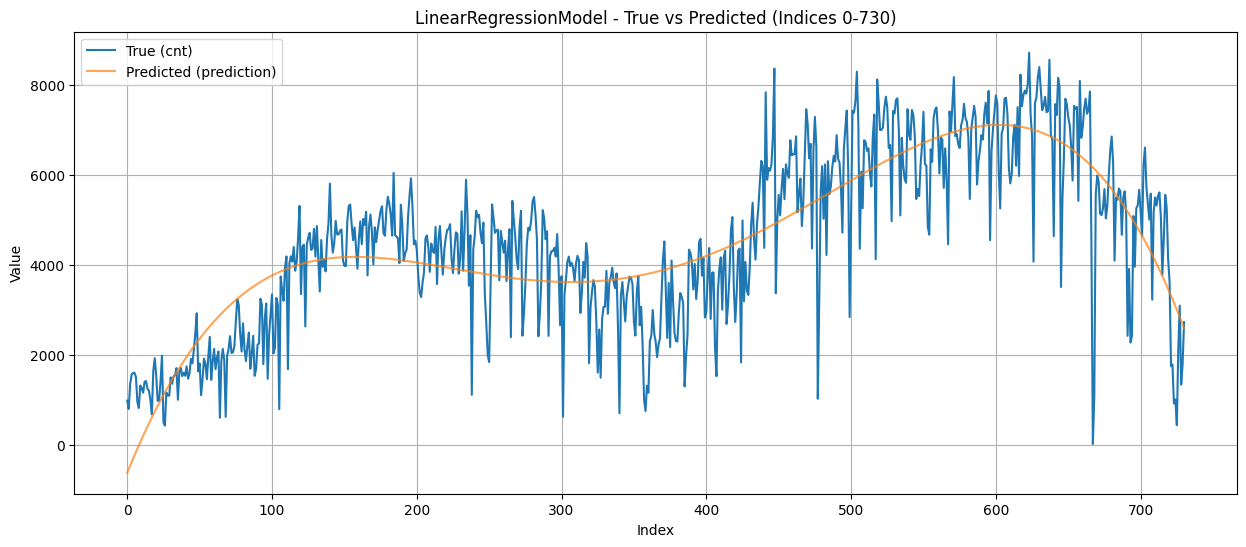

In [ ]:
# model3 (stopień 4) wyglądał najlepiej
chosen_trend_model = model3
print("\n--- Details for Chosen Trend Model (Experiment 3) ---")

lr_stage_trend = chosen_trend_model.stages[-1]

print("Coefficients:", lr_stage_trend.coefficients)
print("Intercept:", lr_stage_trend.intercept)

print('Iterations:', lr_stage_trend.summary.totalIterations)

print("\nFinal plot for the chosen trend model:")
plot(df.orderBy('instant'), chosen_trend_model, label_col='cnt', prediction_col='prediction')


In [86]:
# !pip install seaborn
# !pip install statsmodels

Converting Spark DataFrame to Pandas DataFrame for time series analysis...
Pandas DataFrame created with 731 rows.
Calculating shifted series...
Calculating and plotting autocorrelation matrix...


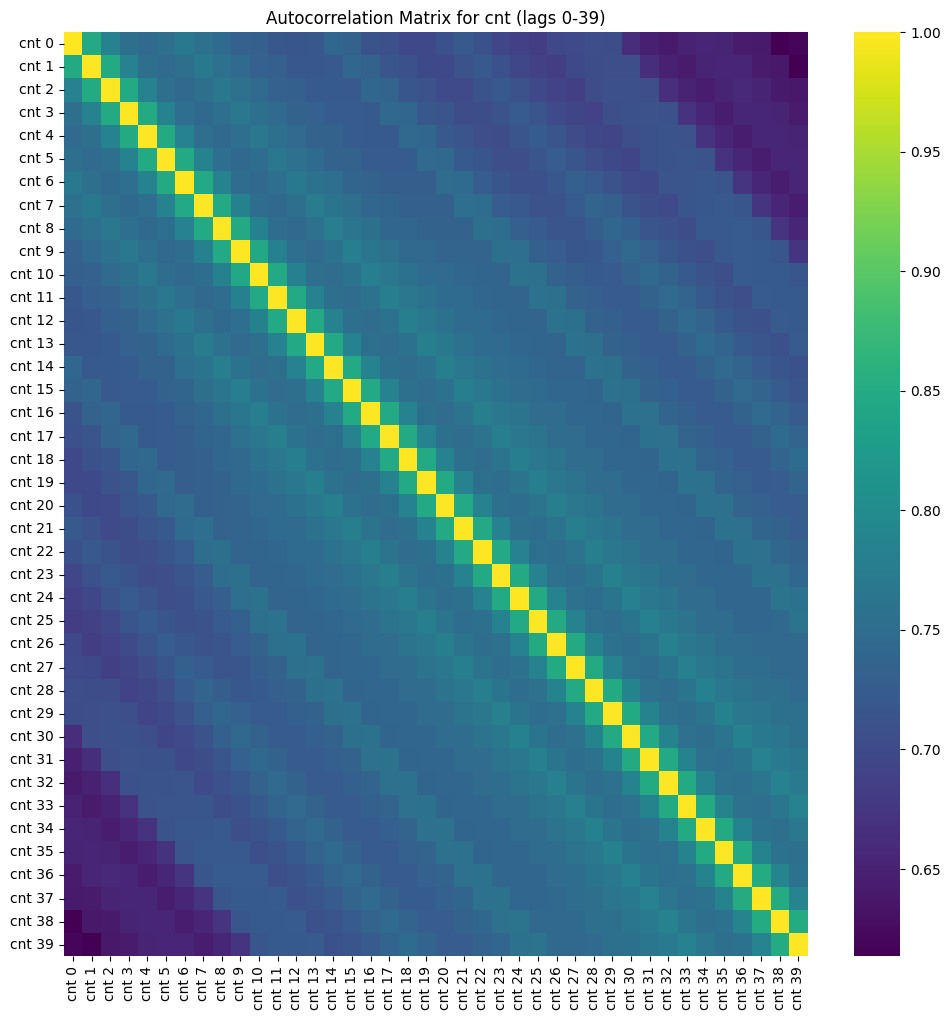


Observe the heatmap for bright bands indicating correlations at specific lags.
Strong correlation is expected at lag 0 (diagonal) and potentially at lags related to weekly (7) or monthly patterns.


In [87]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

print("Converting Spark DataFrame to Pandas DataFrame for time series analysis...")
pdf = df.orderBy('instant').select('instant', 'cnt').toPandas()
print(f"Pandas DataFrame created with {len(pdf)} rows.")

print("Calculating shifted series...")
shifted_range = 40
shifted = [pd.DataFrame(data = pdf.cnt).shift(i) for i in range(shifted_range)]
for i in range(len(shifted)):
  shifted[i].columns=['cnt '+str(i)]

df_shifted = pd.concat(shifted,axis=1)

print("Calculating and plotting autocorrelation matrix...")
corr_mat = df_shifted.corr()

plt.rcParams['figure.figsize'] = (12, 12)
sn.heatmap(corr_mat,xticklabels=df_shifted.columns,yticklabels=df_shifted.columns, cmap='viridis')
plt.title(f'Autocorrelation Matrix for cnt (lags 0-{shifted_range-1})')
plt.show()

print(f"\nObserve the heatmap for bright bands indicating correlations at specific lags.")
print(f"Strong correlation is expected at lag 0 (diagonal) and potentially at lags related to weekly (7) or monthly patterns.")



Plotting Autocorrelation Function (ACF)...


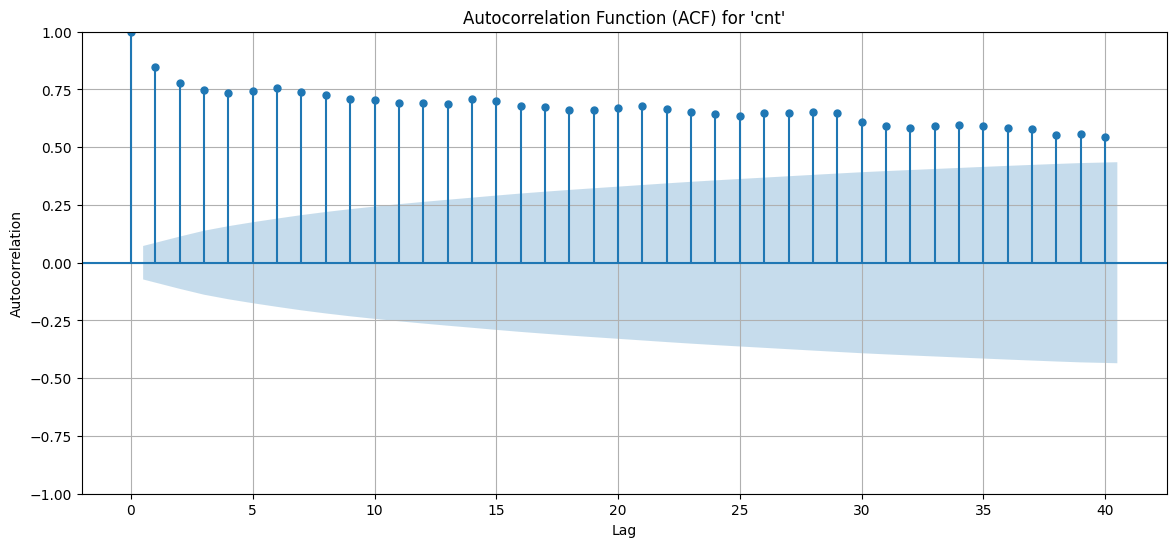


Observe the ACF plot. Significant peaks (bars extending beyond the blue confidence interval)
indicate statistically significant autocorrelation at those lags.
Look for peaks around lag 7 (weekly) and potentially other periodicities.


In [88]:
from statsmodels.graphics.tsaplots import plot_acf

print("\nPlotting Autocorrelation Function (ACF)...")
plt.rcParams['figure.figsize'] = (14, 6)
plot_acf(pdf.cnt, lags=shifted_range)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function (ACF) for 'cnt'")
plt.grid(True)
plt.show()

print(f"\nObserve the ACF plot. Significant peaks (bars extending beyond the blue confidence interval)")
print(f"indicate statistically significant autocorrelation at those lags.")
print(f"Look for peaks around lag 7 (weekly) and potentially other periodicities.")



Performing seasonal decomposition with period=30...
Plotting decomposition components (Trend, Seasonality, Residuals)...


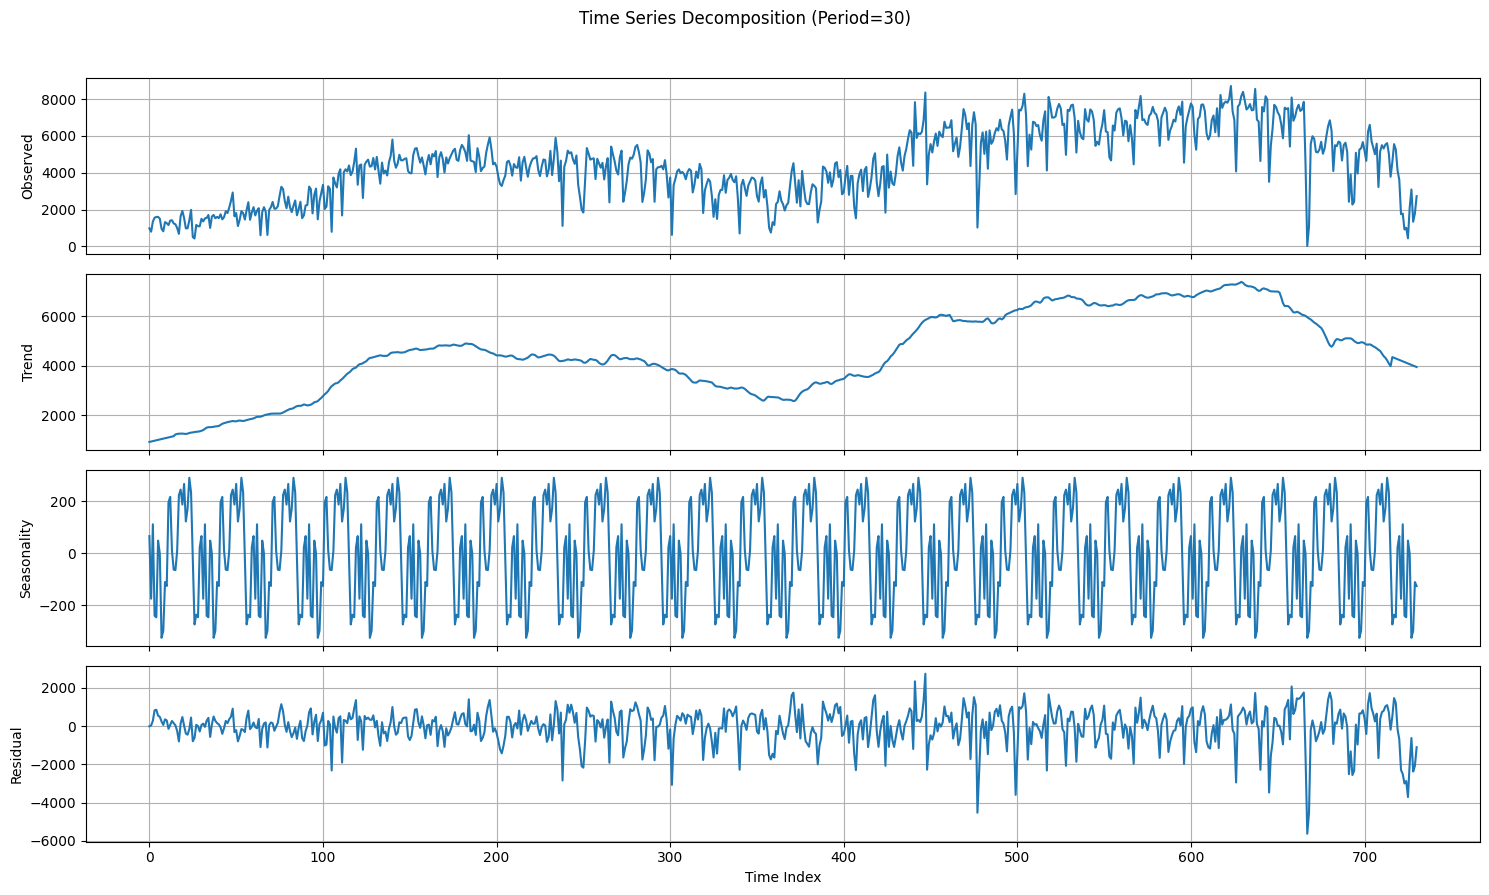

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose

pdf_for_decompose = pdf.set_index(pd.RangeIndex(start=0, stop=len(pdf)))

decomposition_period = 30

print(f"\nPerforming seasonal decomposition with period={decomposition_period}...")

res = seasonal_decompose(pdf_for_decompose['cnt'], model="additive", period=decomposition_period, extrapolate_trend='freq')

print("Plotting decomposition components (Trend, Seasonality, Residuals)...")
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,10), sharex=True)

res.observed.plot(ax=ax1, ylabel="Observed")
ax1.grid(True)
res.trend.plot(ax=ax2, ylabel="Trend")
ax2.grid(True)
res.seasonal.plot(ax=ax3, ylabel="Seasonality")
ax3.grid(True)
res.resid.plot(ax=ax4, ylabel="Residual")
ax4.grid(True)
fig.suptitle(f'Time Series Decomposition (Period={decomposition_period})', y=0.92)
plt.xlabel("Time Index")
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()


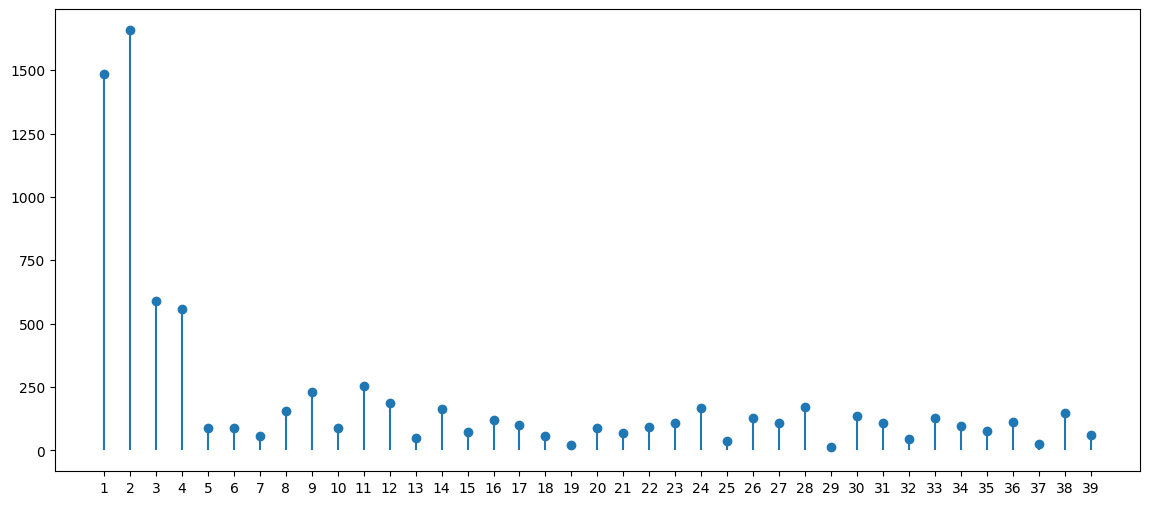

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
 
y = pdf.cnt.to_numpy()
x = np.arange(-y.shape[0]//2,y.shape[0]//2)
 
yf = scipy.fftpack.fft(y)
 
N=y.shape[0]
 
yf = scipy.fftpack.fft(y)
yf[0]=0
xf = np.arange(1,40)
 
plt.scatter(xf, 2.0/N * np.abs(yf[1:40]))
plt.vlines(xf, np.zeros(39),2.0/N * np.abs(yf[1:40]))
plt.xticks(xf)
plt.show()